## ECON 2355 Implementation Exercise 3: Transformers and Language Models

This exercise has two parts:
 - **1: Large Language Models for Text Classification**: This task applies several modern Language models to a sentiment classification task, demonstrating downstream applications of these large language models. It also introduces the popular [huggingface](https://huggingface.co/) framework, an extremely popular API for working with these models, similar to the timm library introduced in the previous exercises.    
 - **2. Generative Language Models**: This task introduces generative language models and demonstrates their text completion abilities. It also demonstrates computing _perplexity_, a key metric for Causal LMs.

### Notes on the class's implementation exercises in general:

 - These exercises are still being finalized! If you encounter problems please don't hesitate to reach out: tom_bryan@fas.harvard.edu

 - You are welcome to download these notebooks and complete them on your local machine, or work on them in colab. If you are hoping to run things on your local machine you will likely want to set up an [Anaconda](https://www.anaconda.com/products/distribution) python environment and run notebooks from either [VS Code](https://code.visualstudio.com/download) or [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html). For your future Deep Learning-oriented endevours, knowing how to set up an environment to run the frameworks and libraries discussed here will likely be important, so it might not be a bad idea to try setting things up locally. On the other hand, working in colab is nice for reproducibility purposes--anyone can run and/or debug your code without problems.

 - Exercises in this class use [PyTorch](https://pytorch.org/get-started/locally/), the [dominant](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) research deep learning python framework. If you have a _compelling_ reason why you wish to become more familiar with another framework, like Tensorflow, reach out and we _may_ be able to accomodate that.

 - In these exercises we'll try to find the sweet spot between providing so much of the code that the implementation is meaningless and leaving so much that the work is overly tedious. Feedback is appreciated!

 - To submit the assignements, please save the exercise as a `.ipynb` file named `ECON_2355_Exercise_{n}_{firstname}_{lastname}.ipynb` and submit to the appropriate place in XXXXX  

 - These exercises are graded as complete/incomplete. _Complete_ is defined as showing effort to complete all of the steps.

 - Many of these exercises are adapted from other courses, tutorials, or other sources. Should you choose there are often other places to look for help/partial solutions. How and when you use those resources are entirely up to you and your learning style. One caveat: outside sources for exercises will likely be less and less common as we progress through the course.  

### Exercise Set 3: Intro to Large Language Models, Sentiment Classification with BERT, and Introp to GPT



### 1. Intro to Large Language Models

This set of exercises introduces the huggingface `transformers` library, which provides a wide variety of pretrained language models. Pretrained language models have (hopefully) grasped much of language's structure and composition via their training procedure and can quickly generalize to other tasks.

This is very similar to how vision models are pretrained on ImageNet, which gives them a broad understanding of how vision works and what features in an image might be important to making determinations about that image. In the same way, language models know how to break text down into its salient features.

Let's start with some necessary imports. Of particular note is the Huggingface `transformers` library, which will provide most of our Language Model support.

In [ ]:
import os
import torch
from PIL import Image
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from transformers import pipeline, BertTokenizer, BertModel, BertForPreTraining

BERT is a masked language model. In essence, it is trained to predict the token masked by a `[MASK]` token in a given sentence.

You can see a good example of this task by using the `fill-mask` pipeline option, as shown here. Calling `unmasker` on a sentence containing the `[MASK]` token will provide the five most likely candidates for the masked word. First, we initialize the `unmasker` object:

In [ ]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Then we can try out BERT's masked word prediction task:

In [ ]:
unmasker('BERT is a [MASK] language model.')

[{'score': 0.5778862237930298,
  'token': 3019,
  'token_str': 'natural',
  'sequence': 'bert is a natural language model.'},
 {'score': 0.04521975666284561,
  'token': 4730,
  'token_str': 'programming',
  'sequence': 'bert is a programming language model.'},
 {'score': 0.017899544909596443,
  'token': 10713,
  'token_str': 'finite',
  'sequence': 'bert is a finite language model.'},
 {'score': 0.01588580198585987,
  'token': 8360,
  'token_str': 'functional',
  'sequence': 'bert is a functional language model.'},
 {'score': 0.015394698828458786,
  'token': 5337,
  'token_str': 'formal',
  'sequence': 'bert is a formal language model.'}]

Making predictions like this one of the two essential tasks of BERT. It provides the majority of its token-level understanding. As it learns to infer the masked word, it learns how language is used in context. Feel free to experiment by using different sentences and masking different characters. Are there situations where BERT does better or worse?

Experimenting with these masked examples is also a good way to see some of the biases or inaccuracies enbedded in the model. Try, for example, the input sentence


```
My mother worked hard as a [MASK] to feed our family.
```
compared with
```
My father worked hard as a [MASK] to feed our family.
```

Note that the biases reflected in responses like this do not reflect a problem with the model _per se_, but with the training data provided to the model. BERT and models like it use words in similar contexts as they've seen previously. In this case, BERT has consistently seen "father" associated with historically masculine professions and "mother" with historically feminine ones.

This also explains apparent social, moral, or political stances the model favors. See, for example, responses to:

```
Capitalism is a [MASK] idea.
Socialism is a [MASK] idea.
Communism is a [MASK] idea.
```

Of course, these are just annecdotal examples, although others ([1](https://arxiv.org/pdf/2004.09456.pdf), [2](https://arxiv.org/pdf/2010.00133.pdf)) have proposed methods to quantify this bias.

##### **Applying BERT to Sentiment Classification**

In the following exercises, we will use BERT to predict sentiments coresponding to tweets about US airlines. This [dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) comes from [Kaggle](https://www.kaggle.com/), a good repository for example datasets like this.

We will teach BERT to predict sentiments by finetuning it on this particular task. In particular, we will train the model to adapt its [CLS] token to predict whether a tweet is positive, negative, or neutral in its stance towards airlines.

First, let's bring in the data and show some examples. **Important:** **_You will need a Kaggle account to access this data._** You can make an account at: https://www.kaggle.com/ by clicking "Register." Once you've made an account, you will need to follow the instructions [here](https://www.kaggle.com/docs/api) under **Authentication** to generate a Kaggle API key. Upload the key (the file called `kaggle.json` to colab in the default location (under `content/`) and then run the following cell to download the relevant data.

##### a) **Data and Examples**



In [ ]:
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d crowdflower/twitter-airline-sentiment -p ./airline_tweets
!unzip /content/airline_tweets/twitter-airline-sentiment.zip

 78% 2.00M/2.55M [00:00<00:00, 2.86MB/s]
100% 2.55M/2.55M [00:00<00:00, 3.04MB/s]
Archive:  /content/airline_tweets/twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


This dataset comes in csv format, with a series of columns, including the text of the tweet, the sentiment behind the tweet (one of `postive`, `negative`, or `neutral), and a number of other features like the date, airline the tweet refers to, etc. In this example we will use only the text of the tweet to predict its sentiment, so we will discard the remaining features.

The following cell will bring the data into memory and show some illustrative examples (the data is originally sorted by airline, so they will all be from Virgin America). Click the Magic Wand symbol in the output to see things in a more readable format.

In [ ]:
import pandas as pd

tweets = pd.read_csv('Tweets.csv')[['airline_sentiment', 'text']]
tweets.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


##### b) **Bringing in BERT**

Now that we have our text data, we need to get a model! In this project we will use the BERT Base Uncased from huggingface. You can see more information about that model [here](https://huggingface.co/bert-base-uncased), it is essentially the same as the one described in the original [BERT paper](https://arxiv.org/pdf/1810.04805.pdf). This is one of the most common and widely used LLMs, as you can see from the model's download statistics. It's often instructive to try this model on your tasks first to get a benchmark on performance, before trying other, more task-specific models.

BERT needs two objects to run in its simplest form: the `model` and the `tokenizer`. The `tokenizer` takes arbitrary text sequences and turns them into vectors for the `model`, while the `model` passes the vector through BERT's self attention mechanism to create a dense, feature-rich embedding of the sequence.

The following cell will initialize both parts of BERT:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained("bert-base-uncased")

Now we can try running the model on a sample sentence:

In [ ]:
text = "[CLS] This is a test sentence."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

The `output` object here contains all the BERT output, which consists of (see [here](https://huggingface.co/docs/transformers/model_doc/bert#transformers.models.bert.modeling_bert.BertForPreTrainingOutput) in this case, though other BERT models will have different output formats) the final hidden states for each token, sentence relationship classification predictions, and a loss metric. You can access each of these parts separately.

##### c) **The `[CLS]` token**

You may recall from the lecture that BERT's pretraining has two parts: first, it attempts to predict masked tokens. Second, it attemps to determine if one sentence logically follows another (this is called 'entailment'). BERT input is structured like

```
[CLS] Sentence 1 [SEP] Sentence 2
```

BERT uses a classification head over the output of the `CLS` token to predict whether Sentence 2 logically follows Sentence 1. So, BERT is tuned to produce informative representations for **classifying the entire sequence** in it's `CLS` space.

In a first example, let's see how BERT does at generating predictions based on its original classification task: does one sentence logically follow the other?

Run the model we've initialized over some examples, some of which logically follow each other, and some of which do not. How does BERT do? You can access BERT's classification predictions via `output.seq_relationship_logits`.

**Note:** The model here is not really tuned for classification, and may make incorrect predictions. However, you should see _lower_ values for the first value in `output.seq_relationship_logits` and _higher_ values (they will likely still be negative) for the second value for unrelated sentences.

In [ ]:
follows = 'The location of the earthquake places it within the vicinity of a triple junction between the Anatolian, Arabian, and African plates. The mechanism and location of the earthquake are consistent with it having occurred in either the East Anatolian Fault zone or the Dead Sea Transform Fault Zone.'
does_not_follow = 'The Dead Sea Transform extends north–south from the Red Sea to the Marash Triple Junction where it meets the East Anatolian Fault.' + \
                  'Like certain other upper houses of state and territorial legislatures and the United States Senate, the state Senate can confirm or reject gubernatorial appointments to state departments, commissions, boards, and other state governmental agencies.'

# Encode both sentences using the tokenizer object from before (pass 'add_special_tokens=True' as an argument to the tokenizer)

# Run the model from before over the tokenized text

# Check the outputs and classification scores
print('Follows predictions: {}'.format(follows_output.seq_relationship_logits))
print('Does not follow predictions: {}'.format(not_follows_output.seq_relationship_logits))


##### d) **Adding a classification head**

The example above produces predictions (the final `seq_relatioship_logits` pair) because it has a classification head on top. Here we add a classification head for our problem (classifying airline tweet sentiment) on top of a BERT model.

Now, instead of using the `BertForPreTraining` model, we will switch to the standard `BertModel`, since we no longer need to access the pretraining behavior.

What does a classification head look like? The `CLS` token outputs from the model as a dense, 768-dimensional vector. We will add several linear layers to produce a three-dimensional output, and then add a softmax layer to produce probabilities for each of the classes, positive, negative, and neutral.

In [ ]:
class BertSentimentClassifier(torch.nn.Module):
  def __init__(self, bert_model):
    super(BertSentimentClassifier, self).__init__()
    self.bert_model = bert_model

    # TODO: Create a linear layer and softmax to move from a 768 dimensional vector to a three-dimensional probability vector

  def forward(self, input_ids, mask):
    _, pooled_output = self.bert_model(input_ids = input_ids, attention_mask = mask, return_dict = False)
    # TODO: run the linear layer and softmax over the pooled output (a 768-d vector)
    return

Now initialize `bert_model` as a `transformers.BertModel` object with pretrained weights from `bert-base-uncased`, `tokenizer` as a `transformers.BertTokenizer` object with weights from the same location, and `model` as an instance of our custom classifer class with `bert_model` as its base model.

In [ ]:
# TODO: create a BERT model as described above
bert_model =

# TODO: create a BERT Tokenizer as described above
tokenizer =

# TODO: create an instance of the custom classifer model with bert_model as the base model
model =


##### e) **Preparing to train the model**

Now that we have our encoder, custom model, and data all initialized, we need to set up the standard elements for a PyTorch training loop (similar to the first two exercise sets). In particular, we will need to create PyTorch datasts and dataloaders, an optimizer,

First, we apply a mapping to the data to get numeric classication values.

In [ ]:
mapping = {'negative': 0,
           'neutral': 1,
           'positive': 2}

# TODO: Encode the semtiment classifications by creating a new column in the dataframe (hint `pd.apply` may be useful)
tweets['enc_sentiment'] =

Next, we need to create a dataset object for this dataset. `X` should be the actual texts, while `y` should be the encoded semtiment values.

In [ ]:
# TODO: Finish implementing the TweetDataset object
class TweetDataset:
  def __init__(self, tweet_data):

  def __len__(self):

  def __getitem__(self, i):


Then, as usual, we need to create train, test, and validation sets. We also need to create `torch.utils.data.DataLoader` objects from the various datasets. Let's again use **80% train, 10% validation, and 10% test.**

In [ ]:
tweet_dataset = TweetDataset(tweets)

# TODO: Split data into three sets, with proportions defined above
train_set, val_set, test_set =

# TODO: Create dataloaders for the data
train_loader =
val_loader =
test_loader =

Now we need to create the remaining objects for our training loop. Move the model to the GPU and create a `CrossEntropyLoss` loss function and an `Adam` optimizer.

In [ ]:
learning_rate = 1e-6

#TODO: Move the model to the GPU
model =

# TODO: create an Adam optimizer for the model
optim =

# TODO: create a cross entropy loss function
loss_fn =

##### f) **Training the model**

Finally, create a training loop for this model. This will look very similar to previous training loops, with a few exceptions:
- Input will have to be tokenized _before_ being moved onto the GPU (sine the tokenizer is still on the CPU)
- Both the `input_ids` and `attention_mask` attribues of the encoded input will need to be moved to the GPU
- Running the model over the input data will need to take both the input ids and attention mask as inputs

In [ ]:
num_epochs = 5

for _ in range(num_epochs):

  model.train()
  for X, y in tqdm(train_loader):
    # TODO: tokenize the input

    # TODO: move the encoded input ids, encoded attention mask, and y to the GPU

    # TODO: Run the model over the input, compute the loss, zero the gradients, backpropagate, and step the optimzer

  model.eval()
  n_correct = 0
  for X, y in tqdm(val_loader):
    # TODO: complete the evaulation loop, computing validation accuracy

  print(f'Val Accuracy epoch {_ + 1}: {n_correct / len(val_set)}')

After five epochs, you should see accuracy in the 80-90% range. If you don't, consider checking the model you defined earlier for any possible errors.

##### g) **A more direct approach**

While we can adapt the general BERT model to just about any task, there are also many models (provided by huggingface or other sites) pretrained for a specific task. In the majority of cases, if you have a widely-used data source (like twitter, in our case) and a broad, often-explored task (like sentiment classification, in our case) there is likely a variety of pretrained models to choose from.

When conducting social science research, we usually want to choose models best suited for our tasks to minimize the training and compute time needed. Spending some time finding models pre-trained for a data source or task can improve performance and save a lot of time.

In this case we can use the [Twitter-roBERTa for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) model, provided through huggingface by [a team of NLP researchers with the University of Cardiff](https://arxiv.org/pdf/2202.03829.pdf). This model is much easier to work with and can be expected to provide more initial knowledge than the first. It:
- Has been pretrained on tweets, unlike BERT
- Has already been finetuned to classify sentiments

The code below will intialize the model and tokenizer for you:

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Inputting a sequence into the model will produce a list of pre-softmax outputs for Negative, Neutral, and Positive. We will need to recreate a custom classifier, but **the only change you should need to make from the earlier classifier is removing the linear layer** (since that is provided in the finetuned model)

In [ ]:
# TODO Create a RoBerta sentiment classifer, very similar to the previous custom classifier.
class RoBertaSentimentClassifier(torch.nn.Module):
  def __init__(self, bert_model):
    super(RoBertaSentimentClassifier, self).__init__()
    self.bert_model = bert_model

    # TOOD: Create a softmax layer
    self.softmax = torch.nn.Softmax()

  def forward(self, input_ids, mask):
    pooled_output = self.bert_model(input_ids = input_ids, attention_mask = mask, return_dict = False)[0]

    # TODO: run softmax over the output
    return

Now we need to move the model to the GPU, and create an optimizer and loss function again.

In [ ]:
learning_rate = 1e-6
model = RoBertaSentimentClassifier(roberta_model)

#TODO: Move the model to the GPU
model =

# TODO: create an Adam optimizer for the model
optim =

# TODO: create a cross entropy loss function
loss_fn =

This model should preform well zero-shot on our data, but we can improve preformance by training a bit more on our specific dataset (so that the model can get used to airline-specific terms, for example).

In this last step, you need to recreate the training loop from above. It should be an exact copy-paste. We should make one adjustment, however: run an validation loop _first_ (before doing any training) so that you can measure the model's zero-shot performance. How much does the model improve from that benchmark? Does the model converge faster or slower than the bert-base model? Is final accuracy (after five epochs) higher or lower?

In [ ]:
num_epochs = 5

# TODO: complete an evaulation loop BEFORE training, computing zero-shot accuracy

for _ in range(num_epochs):

  # TODO complete training loop as above (should be copy-paste)



Hopefully this exercise has provided a window into not only sentiment classification, but downstream language tasks in general. The system used here (finding a pretrained model, adapting it to a specific task, and then finetuning) will generalize well across datasets and language tasks.

### 2. Generative Language Models

This brief exercise introduces Generative Language Models, focusing on GPT-2. Generative Language Models are trained for next token prediction, meaning they try to predict the next word in a sequence.

Here we experiment with a generative model, use it to generate text, and introduce **perplexity,** a measure of how likely the model thinks a particular token is given its context.  

##### a) **Generating Text**

First, let's create a GPT-2 model. GPT-2 is a causal language model created by OpenAI. It uses a similar architecture to recent, advanced models like Chat GPT and GPT-4. However, GPT-2's largest version contains 1.5 Billion parameters while GPT-4 is [rumored](https://en.wikipedia.org/wiki/GPT-4) to use over 1 trillion.

You can read lots more about GPT-2 in [its original paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf).

Let's start by initializing a pipeline to start experimenting with GPT-2:

In [12]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2-medium')
set_seed(42)

Now, just like with BERT, we can use the `pipeline` to generate text completing sample sequences:

In [ ]:
generator("Generative Language models are useful for", max_length=15, num_return_sequences=5)

The model being used here is not particularly advanced, so completions will not be of the quality/aparent intelligence of models like Chat GPT, if you are familiar with its outputs. If you would like, experiment with a few more input sequences and see what the model can and cannot do. On many tasks, GPT-2 will do much, much worse than more recent GPT models. On SQUaD, an open-domain question answering benchmark, GPT-2 correctly answers only 4.1% of questions.

For example, you might try requesting facts like:

```
Who was the first president of the United States?
```

which GPT-2 will likely fail to answer correctly.


Importantly, **GPT-2 Can Require a lot of context to perform typical language model tasks.** For example, prompting with an example like the following (taken from the [CoQA dataset](https://stanfordnlp.github.io/coqa/)), the model is much more likely to be successful:

In [ ]:
text = "The 2008 Summer Olympics torch relay was run from March 24 until August 8, 2008, prior to the 2008 Summer Olympics, with the theme of “one world, one dream”. Plans for the relay were announced on April 26, 2007, in Beijing, China. The relay, also called by the organizers as the “Journey of Harmony”, lasted 129 days and carried the torch 137,000 km (85,000 mi) – the longest distance of any Olympic torch relay since the tradition was started ahead of the 1936 Summer Olympics.\n After being lit at the birthplace of the Olympic Games in Olympia, Greece on March 24, the torch traveled to the Panathinaiko Stadium in Athens, and then to Beijing, arriving on March 31. From Beijing, the torch was following a route passing through six continents. The torch has visited cities along the Silk Road, symbolizing ancient links between China and the rest of the world. The relay also included an ascent with the flame to the top of Mount Everest on the border of Nepal and Tibet, China from the Chinese side, which was closed specially for the event.\n Q: What was the theme\n A: “one world, one dream”.\n Q: What was the length of the race?\n A: 137,000 km\n Q: Was it larger than previous ones?\n A: No\n Q: Where did the race begin?\n A: Olympia, Greece\n Q: Is there anything notable about that place?\n A: birthplace of Olympic Games\n Q: Where did they go after?\n A: Athens\n Q: How many days was the race?\n A: seven\n Q: Did they visit any notable landmarks?\n A: Panathinako Stadium\n Q: Did they climb any mountains?\n A:"

result = generator(text, max_length=400, num_return_sequences=1)[0]['generated_text']
completion = result.split('Did they climb any mountains?')[1]

print('**Prompt**\n\n')
print(text)
print('\n\n**Completion**\n\n')
print(completion)

##### b) Comparing Likelihoods & Perplexity

Given the apparent weaknesses in GPT-2's question answering abilities, in what senses did it represent a breakthrough in generative language modeling? For many language tasks, OpenAI compared the likelyhood of several words and confirmed than its predictions more strongly predicted the correct words.

**First**, let's take a closer look at how GPT-2 is making its predictions. We'll start by importing a few necessary objects:

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy
import torch

Now we will create a tokenizer and model for GPT-2, in a very similar way to how we worked with BERT earlier in the exercise:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

Now we can use the model for determining the likelihood of a word, according to GPT-2's training. The following example shows how to compute the five most likely words following a passage:

In [ ]:
text = 'Economics is a very interesting' #Sample sentence
inputs = tokenizer(text, return_tensors='pt') # Tokenize the input with the pretrained GPT-2 tokenizer
logits = model(**inputs).logits # Use the model to get scores for each word

# print(logits.shape) # logits is a score for each token in the vocabulary for each word in the sequence, plus the next word following the sequence

final_word_logits = logits[0, -1, :] # Get the scores for the next word
pred_indices = torch.topk(final_word_logits, 5).indices # Get the five most likely completing words
pred_probs = torch.softmax(final_word_logits, 0)[pred_indices] # Find the corresponding softmax likelihoods

# Print the five most likely completing words with their softmax likelihoods
for idx, prob in zip(pred_indices, pred_probs):
    print(tokenizer.decode(idx.item()), round(prob.item(), 2))

**Perplexity**


[Perplexity](https://en.wikipedia.org/wiki/Perplexity) measures the model's "surprise" at seeing new data. Essentially, it models how well a model's training allows it to model a new sentence. In particular, Perplexity is the exponent of the model's loss, which is the average negative log likelyhood of each word in the sequence given its context:

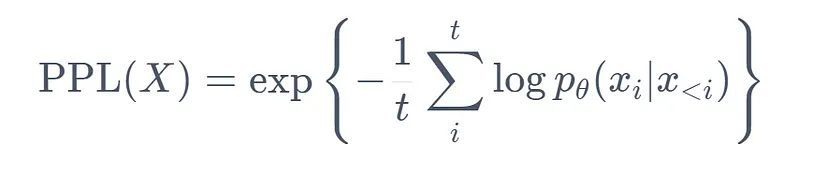


The **final part of this exercise** is to create a function that computes the perplexity of a sentence. The function should take in a `tokenizer` object, a `model` object, and a text sentence. It should then compute $log( p_\theta(x_i|x_{<i}))$ for each word in the sentence, using the preceding text as the context. It then uses those log likelihoods to compute the perplexity. The skeleton of the function, as well as a few tips for writing it are provided.

You can view Huggingface's implementation of GPT-2 perplexity [here](https://github.com/huggingface/transformers/blob/abf8f54a019ce14b5eaffa68c6dd883be13fe66e/src/transformers/models/openai/modeling_openai.py#L592). (Although this does not include the exponential.) However, consider trying a more readable, iterative approach like the one outlined below.

**Important**: The first word in the sequence is **not** considered when computing perplexity.

In [89]:
# TODO: Create the get_perplexity function
def get_perplexity(tokenizer, model, text = "Economics is a very interesting topic"):

  # Tokenize the inputs

  # Run the inputs through the model, saving the logits

  # Initialize loss at zero
  loss = torch.tensor(0.0)

  # For each logit index (not including the last one), compute the log of softmax probilities.
  # Then, look up the logged softmax probibility of the NEXT (i + 1) token in the input sequence.
  # That value is p(x_i | x_<i)
  # Sum those values


  # Take the exponential of the negative average of summed likelihoods

  # Return the result


Test your function here! Use the tokenizer and model created at the beginning of (b). For the default sentence, the result should be ~27.3

In [ ]:
get_perplexity(tokenizer, model, text = 'Economics is a very interesting topic')

Perplexity is a measure of how "Surprised" the model is to see that text. How does changing the adjective ("interesting") change the perplexity?

**Measuring Model Performance**

Perplexity is often used to measure a model's performance. One way to do this is testing the model's ability to resolve ambiguities in text. One common benchmark for testing ambiguity resolution is the [Winograd Schema Challenge](https://en.wikipedia.org/wiki/Winograd_schema_challenge).

In a [common formulation](https://arxiv.org/pdf/1806.02847.pdf) models are asked to compare sentences with ambiguous words. For example:

_"The trophy doesn't fit in the suitcase because **it** is too big."_

What is too big? If the model "understands" the sentence well, it will realize that **it** refers to the trophy, since it would be illogical for it to refer to the suitcase.

To test the model, we can compare perplexity on the two possible resolutions:

In [ ]:
print(get_perplexity(tokenizer, model, text = 'The trophy doesn\'t fit in the suitcase because the suitcase is too big.'))
print(get_perplexity(tokenizer, model, text = 'The trophy doesn\'t fit in the suitcase because the trophy is too big.'))

Which sentence is the model more surprised to see? You can try the model out on a few more examples (found [here](https://cs.nyu.edu/~davise/papers/WinogradSchemas/WS.html)) or try creating your own.

**An easier way to do this**

In practice, we probably wouldn't compute the perplexity of a sentence like this. Huggingface has implementing this behind the scenes. For a shortcut, we can just compute the model's overall loss and take the exponential. Importantly, this demonstrates the overall goal of training-- reduce perplexity on the training data.

Here is the simplified code:

In [ ]:
inputs = tokenizer("Economics is a very interesting topic", return_tensors='pt')
loss = model(input_ids = inputs['input_ids'], labels = inputs['input_ids']).loss

perplexity = torch.exp(loss)
print(perplexity)